<a href="https://colab.research.google.com/github/mertyyanik/Analysis-with-R/blob/master/gradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd /content/drive/My Drive

In [0]:
!git clone https://github.com/mertyyanik/Grad-CAM-tensorflow

In [0]:
%cd /content/drive/My Drive/Grad-CAM-tensorflow/model

!wget http://download.tensorflow.org/models/resnet_v1_101_2016_08_28.tar.gz

!tar xvf resnet_v1_101_2016_08_28.tar.gz

%cd ..

In [0]:
%cd /content/drive/My Drive/Grad-CAM-tensorflow

In [0]:
%tensorflow_version 1.x

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops.relu_grad(grad, op.outputs[0]), tf.zeros(grad.get_shape()))

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

from slim.nets import resnet_v1

import tensorflow as tf
slim = tf.contrib.slim

import utils

def gradCamLoadWeights():

  # Create tensorflow graph for evaluation
  eval_graph = tf.Graph()
  with eval_graph.as_default():
      with eval_graph.gradient_override_map({'Relu': 'GuidedRelu'}):
          images = tf.placeholder("float", [224, 224, 3])
          labels = tf.placeholder(tf.float32, [1000])
          
          preprocessed_images = utils.resnet_preprocess(images)
          
          with slim.arg_scope(resnet_v1.resnet_arg_scope()):
              with slim.arg_scope([slim.batch_norm], is_training=False):
                  net, end_points = resnet_v1.resnet_v1_101(preprocessed_images, 1000)
          prob = end_points['predictions'] # after softmax
          
          cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(prob)), axis=1)
          print('cost:', cost)
          y_c = tf.reduce_sum(tf.multiply(net, labels), axis=1)
          print('y_c:', y_c)

          # Get last convolutional layer gradient for generating gradCAM visualization
          # print('endpoints:', end_points.keys())
          target_conv_layer = end_points['resnet_v1_101/block4/unit_2/bottleneck_v1']
          target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]

          # Guided backpropagtion back to input layer
          gb_grad = tf.gradients(cost, images)[0]

          init = tf.global_variables_initializer()
          
          # Load resnet v1 weights
          
          # latest_checkpoint = tf.train.latest_checkpoint("model/resnet_v1_50.ckpt")
          latest_checkpoint = "model/resnet_v1_101.ckpt"
          ## Optimistic restore.
          reader = tf.train.NewCheckpointReader(latest_checkpoint)
          saved_shapes = reader.get_variable_to_shape_map()
          variables_to_restore = tf.global_variables()
          for var in variables_to_restore:
            if not var.name.split(':')[0] in saved_shapes:
              print("WARNING. Saved weight not exists in checkpoint. Init var:", var.name)
            else:
              # print("Load saved weight:", var.name)
              pass

          var_names = sorted([(var.name, var.name.split(':')[0]) for var in variables_to_restore
                  if var.name.split(':')[0] in saved_shapes])
          restore_vars = []
          with tf.variable_scope('', reuse=True):
              for var_name, saved_var_name in var_names:
                  try:
                      curr_var = tf.get_variable(saved_var_name)
                      var_shape = curr_var.get_shape().as_list()
                      if var_shape == saved_shapes[saved_var_name]:
                          # print("restore var:", saved_var_name)
                          restore_vars.append(curr_var)
                  except ValueError:
                      print("Ignore due to ValueError on getting var:", saved_var_name) 
          saver = tf.train.Saver(restore_vars)

          dictionary = {}

          dictionary['eval_graph'] = eval_graph
          dictionary['init'] = init
          dictionary['latest_checkpoint'] = latest_checkpoint
          dictionary['prob'] = prob
          dictionary['images'] = images
          dictionary['gb_grad'] = gb_grad
          dictionary['target_conv_layer'] = target_conv_layer
          dictionary['target_conv_layer_grad'] = target_conv_layer_grad
          dictionary['labels'] = labels
          dictionary['saver'] = saver

          return dictionary

def gradCam(image_path, dictionary):
  eval_graph = dictionary['eval_graph']
  init = dictionary['init']
  latest_checkpoint = dictionary['latest_checkpoint']
  prob = dictionary['prob']
  images = dictionary['images']
  gb_grad = dictionary['gb_grad']
  target_conv_layer = dictionary['target_conv_layer']
  target_conv_layer_grad =  dictionary['target_conv_layer_grad']
  labels = dictionary['labels']
  saver = dictionary['saver']

  # Create mini-batch for demo

  img1 = utils.load_image(image_path, normalize=False)
  #img2 = utils.load_image("/content/drive/My Drive/00116_fake_0_.jpg", normalize=False)
  #img3 = utils.load_image("/content/drive/My Drive/00116_real_0_.jpg", normalize=False)

  batch1_img = img1.reshape((1, 224, 224, 3))
  batch1_label = np.array([1 if i == 242 else 0 for i in range(1000)])  # 1-hot result for Boxer
  batch1_label = batch1_label.reshape(1, -1)
  """
  batch2_img = img2.reshape((1, 224, 224, 3))
  batch2_label = np.array([1 if i == 155 else 0 for i in range(1000)])  # 1-hot result for Shih-Tzu
  batch2_label = batch2_label.reshape(1, -1)

  batch3_img = img3.reshape((1, 224, 224, 3))
  batch3_label = np.array([1 if i == 292 else 0 for i in range(1000)])  # 1-hot result for tiger
  batch3_label = batch3_label.reshape(1, -1)
  """
  batch_img = np.concatenate((batch1_img), 0)
  batch_label = np.concatenate((batch1_label), 0)
  batch_size = 1


  # Run tensorflow 

  with tf.Session(graph=eval_graph) as sess:    
      sess.run(init)    
      # sess.run(tf.local_variables_initializer())
      saver.restore(sess, latest_checkpoint)
      
      prob = sess.run(prob, feed_dict={images: batch_img})
      
      # gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad], feed_dict={images: batch_img, labels: prob})
      gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad], feed_dict={images: batch_img, labels: batch_label})    
      
      for i in range(batch_size):
          utils.visualize(batch_img[i], target_conv_layer_value[i], target_conv_layer_grad_value[i], gb_grad_value[i])

In [0]:
dictionary = gradCamLoadWeights()

INFO:tensorflow:Restoring parameters from model/resnet_v1_101.ckpt
grads_val shape: (7, 7, 2048)
gb_viz shape: (224, 3)


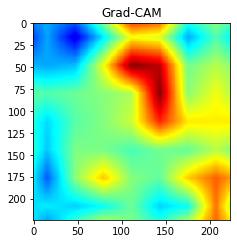

In [0]:
gradCam(image_path = '/content/frame1.jpg', dictionary = dictionary)